# 4. Модель ARIMA (ch22-28)

# Autoregression Models for Forecasting

Авторегрессия - это модель временных рядов, в которой в качестве входных данных для уравнения регрессии используются наблюдения за предыдущие временные шаги, чтобы предсказать значение на следующем временном шаге. Это может выглядеть следующим образом:
* X(t + 1) = b0 + (b1 * X(t)) + (b2 * X(t - 1))

Модель авторегрессии предполагает, что текущие и предыдущие наблюдения временного ряда полезны для прогнозирования значения на следующем временном шаге. 

Существует быстрый визуальный способ проверки того, есть ли автокорреляция во временном ряде. Можно построить диаграмму рассеяния для наблюдения на текущем временном шаге (t) с наблюдением на предыдущем временном шаге (t-1). 

In [5]:
import os
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

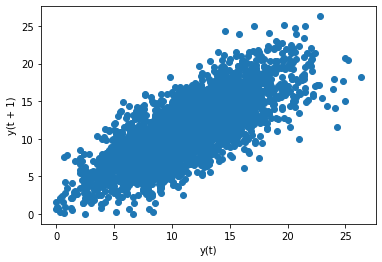

In [6]:
# lag plot of time series
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
lag_plot(series)
pyplot.show()

Можно рассчитать коэффициент корреляции Пирсона между текущими и лаговыми значениями.

In [2]:
# correlation of lag=1
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

           t      t+1
t    1.00000  0.77487
t+1  0.77487  1.00000


Мы можем рассчитать коэффициент корреляции для каждой лаговой переменной. Это может очень быстро дать представление о том, какие лаговые переменные могут быть хорошими кандидатами для использования в прогнозной модели и как с течением времени меняются отношения между наблюдением и его историческими значениями. 

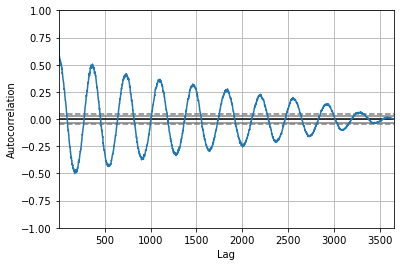

In [3]:
# autocorrelation plot of time series
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
autocorrelation_plot(series)
pyplot.show()

Библиотека Statsmodels предлагает другой вид коррелограммы.

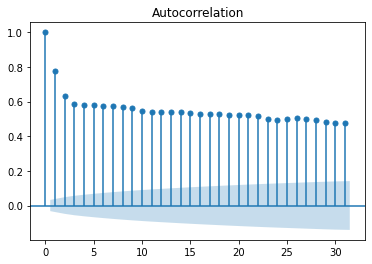

In [4]:
# autocorrelation plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_acf(series, lags=31)
pyplot.show()

Допустим, мы хотим разработать модель для прогнозирования последних 7 дней минимальных температур с учетом всех предыдущих наблюдений. Простейшая модель, которую мы могли использовать, чтобы сделать предсказания, - это равенство следующего наблюдения предыдущему. Мы можем назвать это моделью настойчивости. Она обеспечивает базовый уровень прогноза, который мы можем сравнить с прогнозом по модели авторегрессии. 

Test RMSE: 1.850


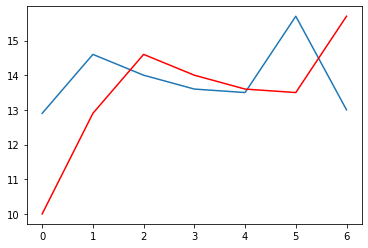

In [5]:
# evaluate a persistence model
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
	return x
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Модель авторегрессии - это модель линейной регрессии, в которой в качестве входных переменных используются запаздывающие (лаговые) переменные. 

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


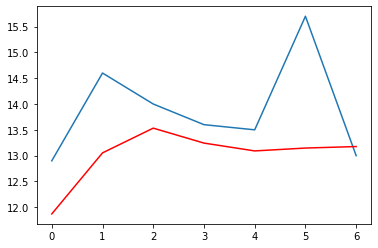

In [6]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Библиотека Statsmodels не позволяет легко обновлять модель по мере появления новых наблюдений.Один из способов - заново обучать модель авторегрессии каждый день в виде новых наблюдений по мере того, как они становятся доступными. Альтернативой было бы использовать оцененные коэффициенты и делать прогнозы вручную. Для этого нужно извлечь коэффициенты из модели и использовать их в уравнении регрессии для создания новых прогнозов: yhat = b0 + (b1 * X1) + (b2 * X2) ... (bn * Xn)

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


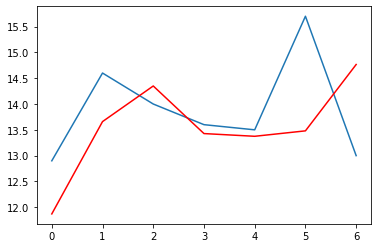

In [7]:
# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Moving Average Models for Forecasting

Остаточные ошибки прогнозов временного ряда являются еще одним источником информации, которую можно использовать в моделировании. Сами остаточные ошибки образуют временной ряд, который может иметь временную структуру. Простая модель авторегрессии этой структуры может быть использована для предсказания ошибки прогноза, которая в свою очередь, может использоваться для корректировки прогнозов. Этот тип модели называется моделью скользящего среднего. Не стоит путать со сглаживанием скользящей средней. 

Рассчитаем ошибки прогноза на основе модели настойчивости: residual error = expected - predicted

In [1]:
# calculate residual errors for a persistence forecast model
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# skill of persistence model
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(residuals.head())

Test RMSE: 9.151
      0
0   9.0
1 -10.0
2   3.0
3  -6.0
4  30.0


Мы можем смоделировать временной ряд остаточной ошибки, используя модель авторегрессии. Это линейная регрессионная модель, которая создает взвешенную линейную сумму запаздывающих членов остаточной ошибки. Например: error(t + 1) = b0 + (b1 * error(t)) + (b2 * error(t - 1)) ... + (bn * error(t - n))

In [4]:
# autoregressive model of residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AutoReg(train_resid, lags=15)
model_fit = model.fit()
print('Coef=%s' % (model_fit.params))

Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Спрогнозируем ошибку прогноза по авторегрессионной модели для ошибок прогноза.

predicted error=1.155523, expected error=9.000000
predicted error=-7.108809, expected error=-10.000000
predicted error=3.007486, expected error=3.000000
predicted error=-0.756446, expected error=-6.000000
predicted error=5.511163, expected error=30.000000
predicted error=-19.991264, expected error=-28.000000
predicted error=4.842429, expected error=2.000000
predicted error=3.050883, expected error=9.000000
predicted error=-5.141585, expected error=-7.000000
predicted error=1.161119, expected error=1.000000
predicted error=-0.241928, expected error=-9.000000
predicted error=9.159826, expected error=21.000000
predicted error=-7.117974, expected error=-13.000000
predicted error=1.182992, expected error=-2.000000
predicted error=2.769363, expected error=11.000000
predicted error=-4.959337, expected error=-11.000000
predicted error=2.566233, expected error=-8.000000
predicted error=9.084498, expected error=6.000000
predicted error=3.020899, expected error=16.000000
predicted error=-6.542098

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


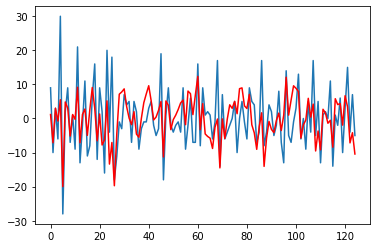

In [5]:
# forecast residual forecast error
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 15
model = AutoReg(train_resid, lags=window)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	expected_error.append(error)
	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]
	predictions.append(pred_error)
	history.append(error)
	print('predicted error=%f, expected error=%f' % (pred_error, error))
# plot predicted error
pyplot.plot(expected_error)
pyplot.plot(predictions, color='red')
pyplot.show()

Модель остаточной ошибки прогноза может быть полезной для улучшения предсказания. Имея хорошую оценку ошибки прогноза на временном шаге, мы можем улучшить предсказания. Например, мы можем добавить ожидаемую ошибку прогноза к прогнозу, чтобы исправить его и в свою очередь улучшить качество модели: improved forecast = forecast + estimated error

predicted=43.155523, expected=51.000000
predicted=43.891191, expected=41.000000
predicted=44.007486, expected=44.000000
predicted=43.243554, expected=38.000000
predicted=43.511163, expected=68.000000
predicted=48.008736, expected=40.000000
predicted=44.842429, expected=42.000000
predicted=45.050883, expected=51.000000
predicted=45.858415, expected=44.000000
predicted=45.161119, expected=45.000000
predicted=44.758072, expected=36.000000
predicted=45.159826, expected=57.000000
predicted=49.882026, expected=44.000000
predicted=45.182992, expected=42.000000
predicted=44.769363, expected=53.000000
predicted=48.040663, expected=42.000000
predicted=44.566233, expected=34.000000
predicted=43.084498, expected=40.000000
predicted=43.020899, expected=56.000000
predicted=49.457902, expected=44.000000
predicted=45.328116, expected=53.000000
predicted=45.225588, expected=55.000000
predicted=48.705924, expected=39.000000
predicted=44.166344, expected=59.000000
predicted=45.621871, expected=55.000000


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


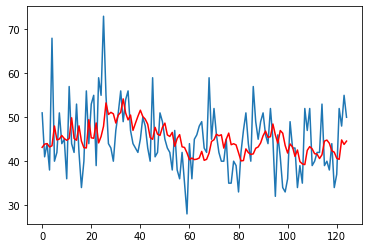

In [6]:
# correct forecasts with a model of forecast residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 15
model = AutoReg(train_resid, lags=15)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_y)):
	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]
	# correct the prediction
	yhat = yhat + pred_error
	predictions.append(yhat)
	history.append(error)
	print('predicted=%f, expected=%f' % (yhat, test_y[t]))
# error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predicted error
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

# ARIMA Model for Forecasting

Популярным и широко используемым статистическим методом прогнозирования временных рядов является модель ARIMA. ARIMA - это аббревиатура от AutoRegressive Integrated Moving Average. Это класс модели, которая фиксирует набор различных стандартных временных структур в данных временных рядов. 

Аббревиатура ARIMA носит описательный характер и захватывает ключевые аспекты модели:
* AR: авторегрессия. Модель, использующая зависимые отношения между наблюдениями и некоторым количеством запаздывающих наблюдений.
* I: интегрированный. Использование разности исходных наблюдений (например, вычитание наблюдения из наблюдения на предыдущем временном шаге), чтобы сделать временной ряд стационарным.
* MA: скользящая средняя. Модель, которая использует зависимость между наблюдением и остаточной ошибкой модели скользящего среднего, примененной к запаздывающим наблюдениям. 

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


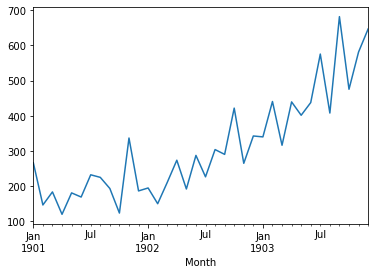

In [1]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


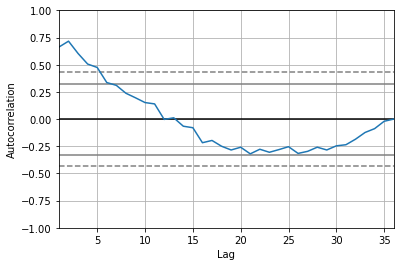

In [2]:
# autocorrelation plot of time series
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# autocorrelation plot
autocorrelation_plot(series)
pyplot.show()

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'stat

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Mon, 31 May 2021   AIC                            406.340
Time:                        14:01:10   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.001       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

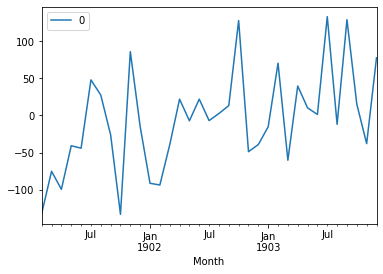

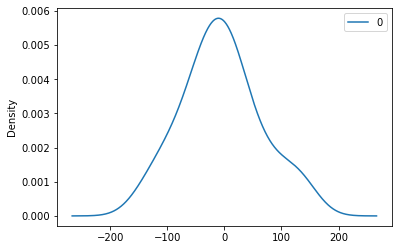

                0
count   35.000000
mean    -5.495197
std     68.132883
min   -133.296593
25%    -42.477867
50%     -7.186558
75%     24.748358
max    133.238000


In [3]:
# fit an ARIMA model and plot residual errors
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'stat

predicted=349.117715, expected=342.300000
predicted=306.512978, expected=339.700000
predicted=387.376355, expected=440.400000
predicted=348.154273, expected=315.900000
predicted=386.308802, expected=439.300000
predicted=356.082135, expected=401.300000
predicted=446.379453, expected=437.400000
predicted=394.737329, expected=575.500000
predicted=434.915434, expected=407.600000
predicted=507.923337, expected=682.000000
predicted=435.482976, expected=475.300000
predicted=652.743757, expected=581.300000
predicted=546.343410, expected=646.900000
Test RMSE: 83.417


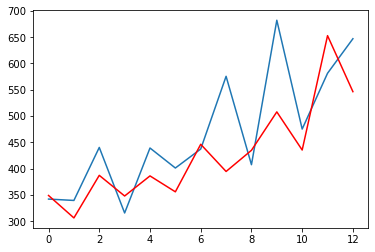

In [4]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Autocorrelation and Partial Autocorrelation

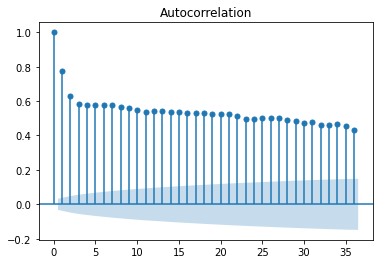

In [2]:
# ACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_acf(series)
pyplot.show()

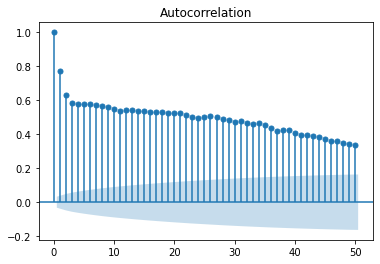

In [3]:
# zoomed-in ACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_acf(series, lags=50)
pyplot.show()

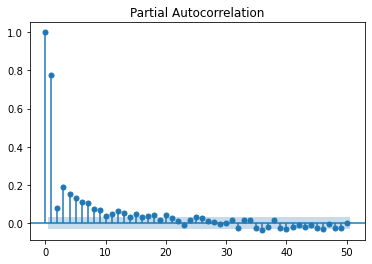

In [4]:
# PACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
plot_pacf(series, lags=50)
pyplot.show()

# Grid Search ARIMA Model Hyperparameters

In [2]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.308
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=134.176
ARIMA(0, 1, 1) RMSE=97.766
ARIMA(0, 1, 2) RMSE=79.413
ARIMA(0, 2, 0) RMSE=259.499
ARIMA(0, 2, 1) RMSE=135.362
ARIMA(1, 0, 0) RMSE=152.030
ARIMA(1, 0, 2) RMSE=85.390
ARIMA(1, 1, 0) RMSE=84.388
ARIMA(1, 1, 1) RMSE=83.688
ARIMA(1, 2, 0) RMSE=136.411
ARIMA(2, 0, 0) RMSE=100.879
ARIMA(2, 1, 0) RMSE=75.432
ARIMA(2, 1, 1) RMSE=88.089
ARIMA(2, 2, 0) RMSE=99.302
ARIMA(4, 0, 0) RMSE=99.424
ARIMA(4, 1, 0) RMSE=81.545
ARIMA(4, 1, 1) RMSE=82.440
ARIMA(4, 2, 0) RMSE=87.157
ARIMA(4, 2, 1) RMSE=68.519
ARIMA(6, 1, 0) RMSE=82.523
ARIMA(6, 1, 1) RMSE=67.899
ARIMA(6, 2, 0) RMSE=79.127
ARIMA(8, 1, 0) RMSE=81.086
ARIMA(10, 1, 0) RMSE=86.825
Best ARIMA(6, 1, 1) RMSE=67.899


In [3]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=8.189
ARIMA(0, 0, 1) RMSE=7.884
ARIMA(0, 0, 2) RMSE=7.771
ARIMA(0, 1, 0) RMSE=9.167
ARIMA(0, 1, 1) RMSE=7.527
ARIMA(0, 1, 2) RMSE=7.434
ARIMA(0, 2, 0) RMSE=15.698
ARIMA(0, 2, 1) RMSE=9.201
ARIMA(0, 2, 2) RMSE=7.570
ARIMA(1, 0, 0) RMSE=7.802
ARIMA(1, 0, 1) RMSE=7.554
ARIMA(1, 1, 0) RMSE=8.120
ARIMA(1, 1, 1) RMSE=7.425
ARIMA(1, 1, 2) RMSE=7.429
ARIMA(1, 2, 0) RMSE=11.990
ARIMA(2, 0, 0) RMSE=7.697
ARIMA(2, 0, 1) RMSE=7.421
ARIMA(2, 0, 2) RMSE=7.472
ARIMA(2, 1, 0) RMSE=7.713
ARIMA(2, 1, 1) RMSE=7.417
ARIMA(2, 1, 2) RMSE=7.430
ARIMA(2, 2, 0) RMSE=10.373
ARIMA(4, 0, 0) RMSE=7.693
ARIMA(4, 0, 1) RMSE=7.829
ARIMA(4, 0, 2) RMSE=7.461
ARIMA(4, 1, 0) RMSE=7.578
ARIMA(4, 1, 1) RMSE=7.474
ARIMA(4, 1, 2) RMSE=7.463
ARIMA(4, 2, 0) RMSE=8.956
ARIMA(6, 0, 0) RMSE=7.666
ARIMA(6, 0, 1) RMSE=7.713
ARIMA(6, 1, 0) RMSE=7.293
ARIMA(6, 1, 1) RMSE=7.554
ARIMA(6, 1, 2) RMSE=7.463
ARIMA(6, 2, 0) RMSE=8.352
ARIMA(8, 0, 0) RMSE=7.549
ARIMA(8, 0, 1) RMSE=7.565
ARIMA(8, 0, 2) RMSE=7.625
ARIMA(8, 

# Save Models and Make Predictions

Test RMSE: 7.259


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


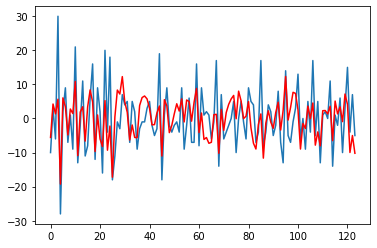

In [1]:
# fit and evaluate an AR model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
# train autoregression
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [2]:
# fit an AR model and save the whole model to file
from pandas import read_csv
from statsmodels.tsa.ar_model import AutoReg
import numpy

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
model = AutoReg(X, lags=6)
model_fit = model.fit()
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
numpy.save('ar_data.npy', X)
# save the last ob
numpy.save('ar_obs.npy', [series.values[-1]])

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [3]:
# load the AR model from file
from statsmodels.tsa.ar_model import AutoRegResults
import numpy
loaded = AutoRegResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[50]


In [4]:
# fit an AR model and manually save coefficients to file
from pandas import read_csv
from statsmodels.tsa.ar_model import AutoReg
import numpy

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
window_size = 6
model = AutoReg(X, lags=window_size)
model_fit = model.fit()
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)
# save the last ob
numpy.save('man_obs.npy', [series.values[-1]])

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [5]:
# load the manually saved model from file
import numpy
coef = numpy.load('man_model.npy')
print(coef)
lag = numpy.load('man_data.npy')
print(lag)
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[-10   3  15  -4   7  -5]
[50]


In [6]:
# load AR model from file and make a one-step prediction
from statsmodels.tsa.ar_model import AutoRegResults
import numpy
# load model
model = AutoRegResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


In [7]:
# load a coefficients and from file and make a manual prediction
import numpy

def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

# load model
coef = numpy.load('man_model.npy')
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
# make prediction
prediction = predict(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


In [8]:
# update the data for the AR model with a new obs
import numpy
# get real observation
observation = 48
# load the saved data
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# update and save differenced observation
diffed = observation - last_ob[0]
data = numpy.append(data, [diffed], axis=0)
numpy.save('ar_data.npy', data)
# update and save real observation
last_ob[0] = observation
numpy.save('ar_obs.npy', last_ob)

In [9]:
# update the data for the manual model with a new obs
import numpy
# get real observation
observation = 48
# update and save differenced observation
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = numpy.append(lag[1:], [diffed], axis=0)
numpy.save('man_data.npy', lag)
# update and save real observation
last_ob[0] = observation
numpy.save('man_obs.npy', last_ob)

# Forecast Confidence Intervals

In [1]:
# summarize the confidence interval on an ARIMA forecast
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit(disp=False)
# forecast
forecast, stderr, conf = model_fit.forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Expected: 50.000
Forecast: 45.878
Standard Error: 6.996
95% Confidence Interval: 32.167 to 59.590


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [2]:
# summarize multiple confidence intervals on an ARIMA forecast
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split data into train and test setes
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit(disp=False)
# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	forecast, stderr, conf = model_fit.forecast(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 45.878 between 36.913 and 54.844
90.0% Confidence Interval: 45.878 between 34.371 and 57.386
95.0% Confidence Interval: 45.878 between 32.167 and 59.590
99.0% Confidence Interval: 45.878 between 27.858 and 63.898


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA ha

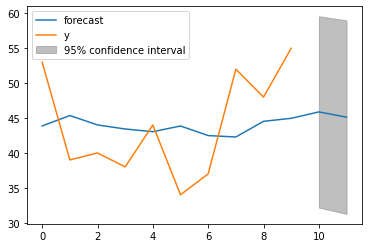

In [3]:
# plot the confidence intervals for an ARIMA forecast
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
# load data
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit(disp=False)
# plot some history and the forecast with confidence intervals
model_fit.plot_predict(len(train)-10, len(train)+1)
pyplot.legend(loc='upper left')
pyplot.show()